In [132]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima_model import ARIMA
from scipy.stats.distributions import chi2
import yfinance
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima

from arch import arch_model

from math import sqrt
sns.set()

In [2]:
raw_data = yfinance.download(tickers="^GSPC ^FTSE ^N225 ^GDAXI", start="1994-01-07", end="2018-01-25",
                            interval="1d", group_by="ticker", auto_adjust=True, treads=True)

[*********************100%***********************]  4 of 4 completed


In [3]:
df_comp = raw_data.copy()

In [4]:
df_comp.head()

^GSPC                                                   \
                  Open        High         Low       Close       Volume   
Date                                                                      
1994-01-06  467.549988  469.000000  467.019989  467.119995  365960000.0   
1994-01-07  467.089996  470.260010  467.029999  469.899994  324920000.0   
1994-01-10  469.899994  475.269989  469.549988  475.269989  319490000.0   
1994-01-11  475.269989  475.279999  473.269989  474.130005  305490000.0   
1994-01-12  474.130005  475.059998  472.140015  474.170013  310690000.0   

                  ^FTSE                                                \
                   Open         High          Low        Close Volume   
Date                                                                    
1994-01-06  3355.300049  3407.699951  3355.300049  3403.000000    0.0   
1994-01-07  3401.399902  3446.800049  3398.699951  3446.000000    0.0   
1994-01-10  3465.699951  3468.100098  3430.000000  3440.600098    0.0   
1994-01-11  3442.500000  3442.500000  3413.500000  3413.800049    0.0   
1994-01-12  3394.800049  3402.399902  3372.000000  3372.000000    0.0   

                   ^N225                                                   \
                    Open          High           Low         Close Volume   
Date                                                                        
1994-01-06           NaN           NaN           NaN           NaN    NaN   
1994-01-07  17842.980469  18131.410156  17787.480469  18124.009766    0.0   
1994-01-10  18186.519531  18567.060547  18186.519531  18443.439453    0.0   
1994-01-11  18481.849609  18671.669922  18373.039062  18485.250000    0.0   
1994-01-12  18447.339844  18807.080078  18301.929688  18793.880859    0.0   

                 ^GDAXI                                                
                   Open         High          Low        Close Volume  
Date                                                                   
1994-01-06  2228.090088  2228.489990  2206.459961  2220.629883    0.0  
1994-01-07  2218.959961  2227.639893  2201.820068  2224.949951    0.0  
1994-01-10  2231.840088  2238.010010  2222.000000  2225.000000    0.0  
1994-01-11  2225.429932  2235.610107  2225.179932  2228.100098    0.0  
1994-01-12  2227.120117  2227.790039  2182.060059  2182.060059    0.0

In [5]:
df_comp['spx'] = df_comp['^GSPC'].Close[:]
df_comp['dax'] = df_comp['^GDAXI'].Close[:]
df_comp['ftse'] = df_comp['^FTSE'].Close[:]
df_comp['nikkei'] = df_comp['^N225'].Close[:]


In [6]:
df_comp = df_comp.iloc[1:]
del df_comp['^GSPC']
del df_comp['^GDAXI']
del df_comp['^FTSE']
del df_comp['^N225']

df_comp = df_comp.asfreq('b')
df_comp = df_comp.fillna(method='ffill')



### Using Returns

In [9]:
df_comp['ret_spx'] =df_comp['spx'].pct_change(1)*100
df_comp['ret_ftse'] =df_comp['ftse'].pct_change(1)*100
df_comp['ret_dax'] =df_comp['dax'].pct_change(1)*100
df_comp['ret_nikkei'] =df_comp['nikkei'].pct_change(1)*100


In [11]:
df_comp.columns

MultiIndex([(       'spx', ''),
            (       'dax', ''),
            (      'ftse', ''),
            (    'nikkei', ''),
            (   'ret_spx', ''),
            (  'ret_ftse', ''),
            (   'ret_dax', ''),
            ('ret_nikkei', '')],
           )

### Normalizing the returns

In [12]:
df_comp['norm_ret_spx'] = df_comp.ret_spx.div(df_comp.ret_spx[1])*100
df_comp['norm_ret_ftse'] = df_comp.ret_ftse.div(df_comp.ret_ftse[1])*100
df_comp['norm_ret_dax'] = df_comp.ret_dax.div(df_comp.ret_dax[1])*100
df_comp['norm_ret_nikkei'] = df_comp.ret_nikkei.div(df_comp.ret_nikkei[1])*100

### Splitting the data

In [14]:
size = int(len(df_comp)*0.8)
df,df_test = df_comp.iloc[:size],df_comp.iloc[size:]

### Fitting A Model

In [15]:
model_ar = ARIMA(df.ftse,order=(1,0,0))
result_ar = model_ar.fit()

### Simple Forecasting

In [17]:
df.tail()

,spx,dax,ftse,nikkei,ret_spx,ret_ftse,ret_dax,ret_nikkei,norm_ret_spx,norm_ret_ftse,norm_ret_dax,norm_ret_nikkei
,,,,,,,,,,,,
Date,,,,,,,,,,,,
2013-03-28,1569.189941,7795.310059,6411.700195,12335.959961,0.405667,0.377295,0.079858,-1.263268,35.497778,-240.774478,3550.136120,-71.676135
2013-03-29,1569.189941,7795.310059,6411.700195,12397.910156,0.000000,0.000000,0.000000,0.502192,0.000000,-0.000000,0.000000,28.493693
2013-04-01,1562.170044,7795.310059,6411.700195,12135.019531,-0.447358,0.000000,0.000000,-2.120443,-39.145947,-0.000000,0.000000,-120.311080
2013-04-02,1570.250000,7943.870117,6490.700195,12003.429688,0.517226,1.232122,1.905762,-1.084381,45.259759,-786.290904,84721.766256,-61.526315
2013-04-03,1553.689941,7874.750000,6420.299805,12362.200195,-1.054613,-1.084635,-0.870106,2.988900,-92.283619,692.170182,-38681.086483,169.586155


In [16]:
## specify a time interval we re predicting 
## the start and end date should be business day else results in an error

In [33]:
start_date = '2013-04-04'
end_date = '2015-01-01'

In [24]:
df_pred = result_ar.predict(start=start_date,end=end_date)

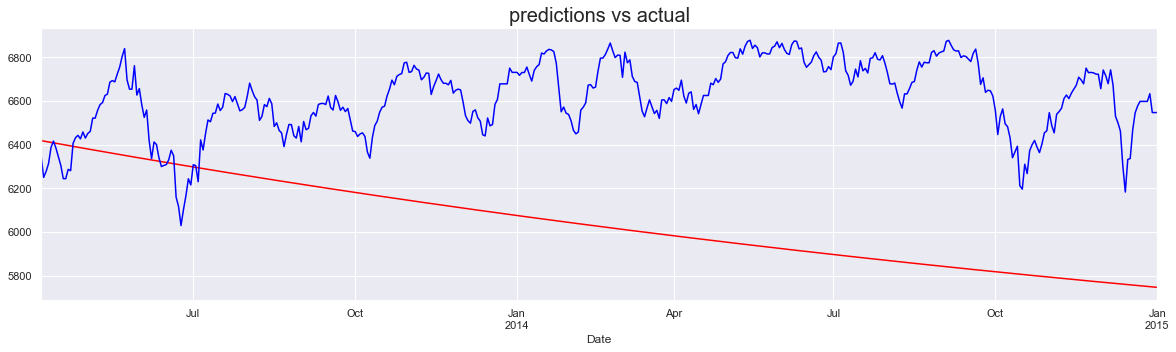

In [26]:
df_pred[start_date:end_date].plot(figsize=(20,5),color='red')
df_test.ftse[start_date:end_date].plot(color='blue')
plt.title('predictions vs actual',size=20)
plt.show()


In [21]:
## this line is not relaistic,, we don't expect prices to be constantly declining
## it means the price today is as high as it is ever going to vbe 
## if this was the case: seller would like to sell today and buyers will buy tomorrow 

In [ ]:
## this issue comes from the model of our choice:
## the predictions are based on the constant and the prices from the previous periods
# every new value is just the fraction of previous one put on top of the constant term 

## thus AR is model is bad at estimating non-stationary data (ftse price)

In [27]:
## over the course of periods actual prices cyclically jump up and down but in a long run,, the acutual prices has
## somewhat upward trend and the predicted line goes downward

In [28]:
## Let us see how simple AR model makes prediction for s&p and dax prices:


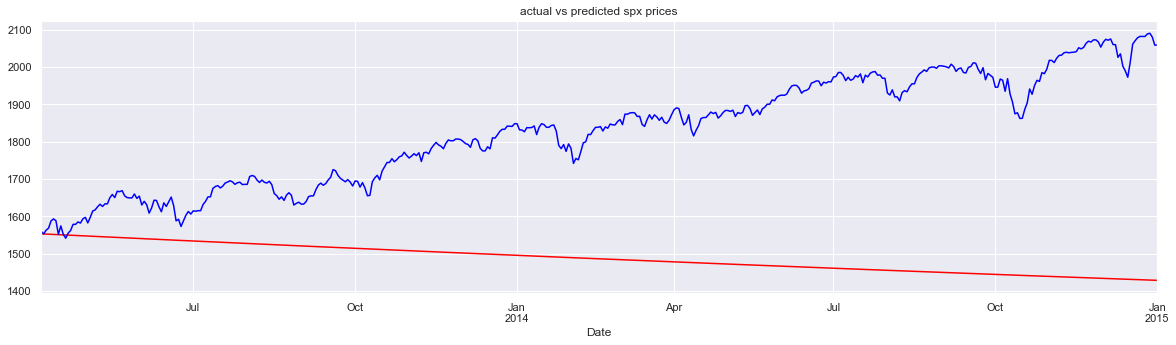

In [30]:
model_ar_spx = ARIMA(df.spx, order=(1,0,0))
result_ar_spx = model_ar_spx.fit()
df_predict_spx = result_ar_spx.predict(start_date,end_date)
df_predict_spx.plot(figsize=(20,5),color='red')
df_test.spx[start_date:end_date].plot(color='blue')
plt.title('actual vs predicted spx prices')
plt.show()

In [31]:
## simple AR model are not good for prediciting non-stationary data

In [32]:
## thus let's use Returns instead of prices

### Using Returns

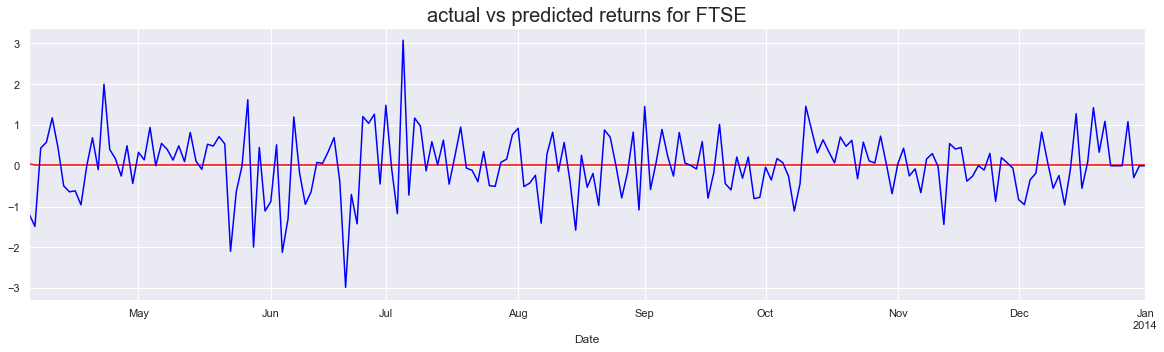

In [44]:
end_date = '2014-01-01'

model_ret_ar = ARIMA(df.ret_ftse[1:], order=(1,0,0))
result_ret_ar = model_ret_ar.fit()

df_predict_ret_ar = result_ret_ar.predict(start_date,end_date)
df_predict_ret_ar[start_date:end_date].plot(figsize=(20,5),color='red')
df_test.ret_ftse[start_date:end_date].plot(color='blue')
plt.title('actual vs predicted returns for FTSE',size=20)
plt.show()

In [41]:
## constant line at the 0 ,, our model makes no prediction since it assumes all the future returns will be 0 ,or extremely
## close to it 
## this tells us the athe coeff of past values as well as values themselves must have absolute value very low

In [42]:
result_ret_ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:               ret_ftse   No. Observations:                 5018
Model:                     ARMA(1, 0)   Log Likelihood               -7927.247
Method:                       css-mle   S.D. of innovations              1.174
Date:                Thu, 21 Jan 2021   AIC                          15860.494
Time:                        11:37:42   BIC                          15880.057
Sample:                    01-10-1994   HQIC                         15867.349
                         - 04-03-2013                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0193      0.016      1.193      0.233      -0.012       0.051
ar.L1.ret_ftse    -0.0241      0.014     -1.710      0.087      -0.052       0.004
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1          -41.4306           +0.0000j           41.4306            0.5000
-----------------------------------------------------------------------------
"""

In [43]:
## the coeff themselves is not significant thus, it makes sense for the model prediction to barely move over time


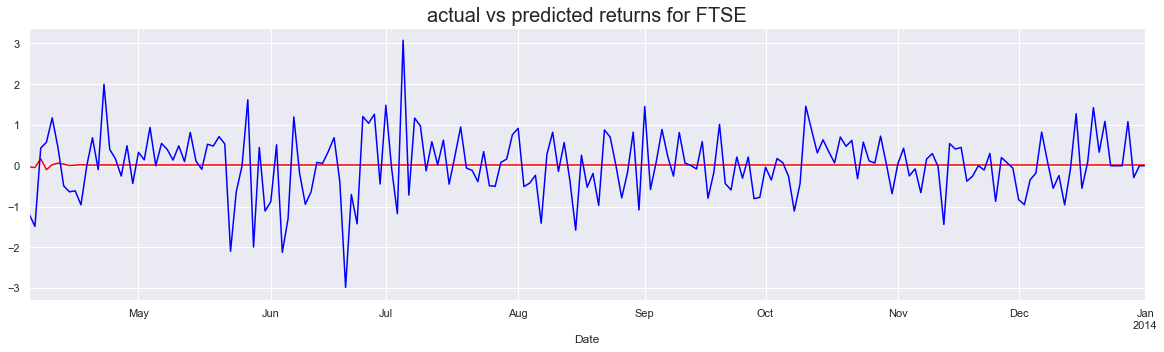

In [47]:
end_date = '2014-01-01'

model_ret_ar = ARIMA(df.ret_ftse[1:], order=(6,0,0))
result_ret_ar = model_ret_ar.fit()

df_predict_ret_ar = result_ret_ar.predict(start_date,end_date)
df_predict_ret_ar[start_date:end_date].plot(figsize=(20,5),color='red')
df_test.ret_ftse[start_date:end_date].plot(color='blue')
plt.title('actual vs predicted returns for FTSE',size=20)
plt.show()

In [48]:
## if we incrase the order of the model to say:5, we see some small shifts among the initial forcast however
## the curve still falttens out very quickly since forcasted value becomes smaller and smaller in absolute value 

## additionaly, we notice that for every single period where the value shifts,, they are moving in the opposote direction
## of where they should be going 
## in the first period they shold be incresing but it has predicted decresing,, as soon as it goes up for a short time


## increasing the order makes little difference in the forecasting capabilities fo model 

### MA model

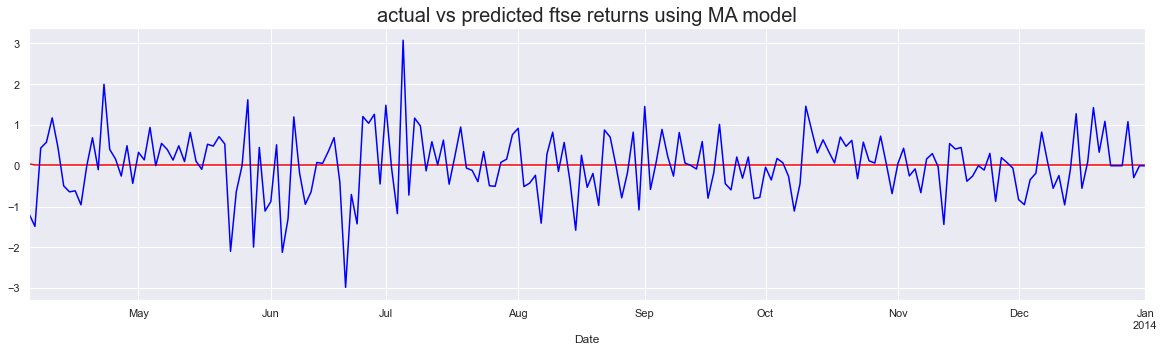

In [51]:
## setting back to benchmark date:
end_date= '2014-01-01'

model_ret_ma = ARIMA(df.ret_ftse[1:],order=(0,0,1))
result_ret_ma = model_ret_ma.fit()
df_pred_ma = result_ret_ma.predict(start_date,end_date)

df_pred_ma[start_date:end_date].plot(figsize=(20,5),color='red')
df_test.ret_ftse[start_date:end_date].plot(color='blue')
plt.title('actual vs predicted ftse returns using MA model',size=20)
plt.show()

In [52]:
## similar patterns: prediction are flat line very close to 0 

In [53]:
df_pred_ma.head() ## all predicted values are very close to 0 and afer the first period dont change 

2013-04-04    0.048276
2013-04-05    0.019312
2013-04-08    0.019312
2013-04-09    0.019312
2013-04-10    0.019312
Freq: B, dtype: float64

In [54]:
## forcasting power of simple AR and MA model is low

### ARMA model

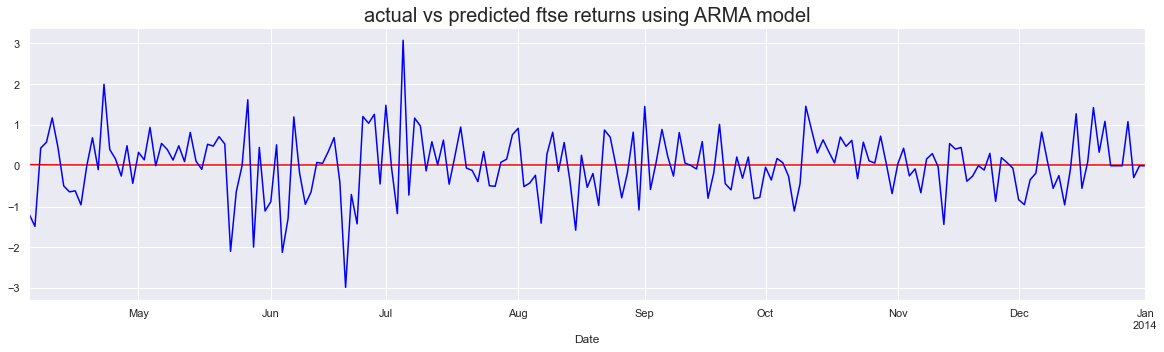

In [57]:
## simple ARMA model

end_date= '2014-01-01'

model_ret_arma = ARIMA(df.ret_ftse[1:],order=(1,0,1))
result_ret_arma = model_ret_ma.fit()
df_pred_arma = result_ret_arma.predict(start_date,end_date)

df_pred_arma[start_date:end_date].plot(figsize=(20,5),color='red')
df_test.ret_ftse[start_date:end_date].plot(color='blue')
plt.title('actual vs predicted ftse returns using ARMA model',size=20)
plt.show()

In [56]:
## same as simple AR and MA mdoels -- a very consistent line of predictions that looks constant from afar 

In [59]:
df_pred_arma.head() 

## we can see value consistenlty decreasing slowly and flattens out eventually

2013-04-04    0.028988
2013-04-05    0.026674
2013-04-08    0.024917
2013-04-09    0.023580
2013-04-10    0.022565
Freq: B, dtype: float64

In [60]:
df_pred_arma.tail()

2013-12-26    0.019349
2013-12-27    0.019349
2013-12-30    0.019349
2013-12-31    0.019349
2014-01-01    0.019349
Freq: B, dtype: float64

In [62]:
## ARMA pprovides more resonable predictions as they dont just die off immediately
## the shifts are always in the same directions (down in this case)
## which means we will still be having constantly decreasing returns , which is not very realistic

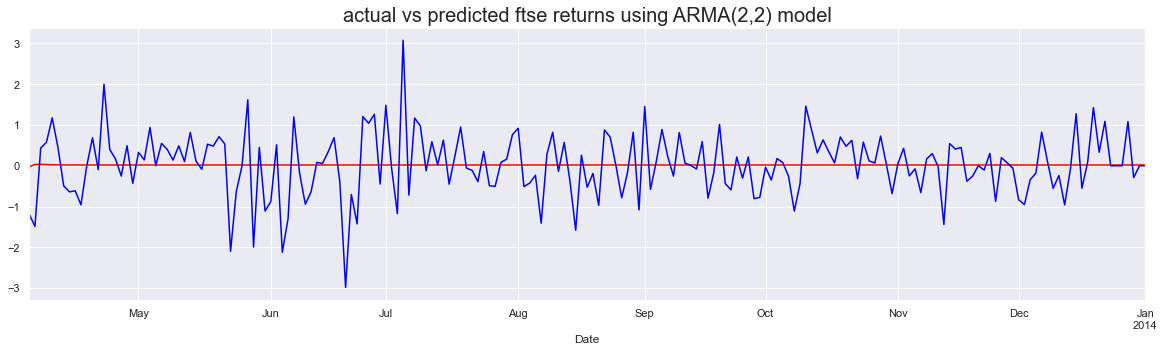

In [64]:
## ARMA using higher orders

end_date= '2014-01-01'

model_ret_ar_2_ma_2 = ARIMA(df.ret_ftse[1:],order=(2,0,2))
result_ret_ar_2_ma_2 = model_ret_ar_2_ma_2.fit()
df_pred_ar_2_ma_2 = result_ret_ar_2_ma_2.predict(start_date,end_date)

df_pred_ar_2_ma_2[start_date:end_date].plot(figsize=(20,5),color='red')
df_test.ret_ftse[start_date:end_date].plot(color='blue')
plt.title('actual vs predicted ftse returns using ARMA(2,2) model',size=20)
plt.show()

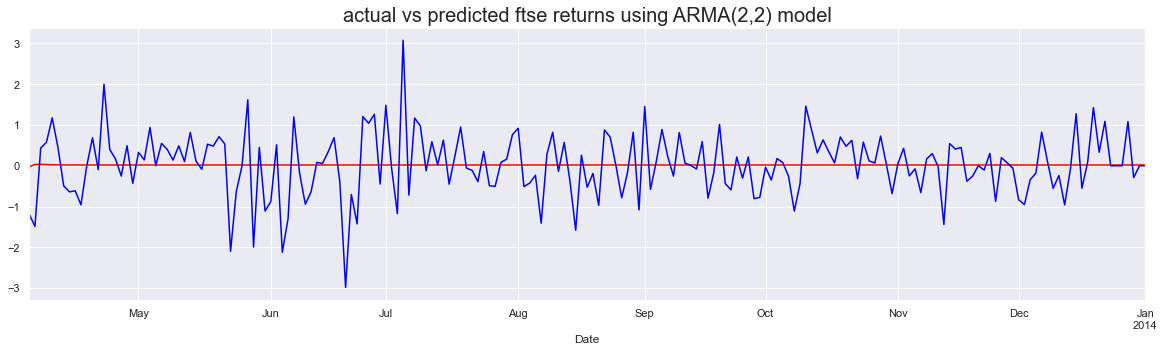

In [65]:

end_date= '2014-01-01'

model_ret_ar_3_ma_3 = ARIMA(df.ret_ftse[1:],order=(3,0,3))
result_ret_ar_3_ma_3 = model_ret_ar_2_ma_2.fit()
df_pred_ar_3_ma_3 = result_ret_ar_3_ma_3.predict(start_date,end_date)

df_pred_ar_3_ma_3[start_date:end_date].plot(figsize=(20,5),color='red')
df_test.ret_ftse[start_date:end_date].plot(color='blue')
plt.title('actual vs predicted ftse returns using ARMA(2,2) model',size=20)
plt.show()

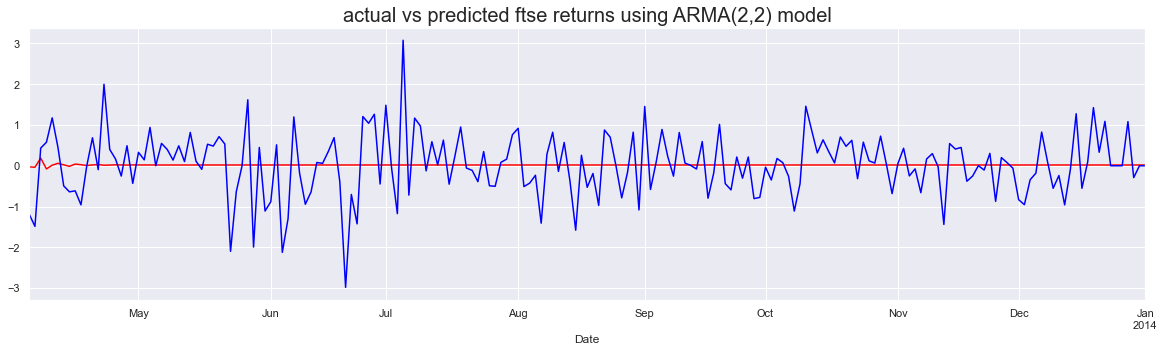

In [66]:

end_date= '2014-01-01'

model_ret_ar_4_ma_4 = ARIMA(df.ret_ftse[1:],order=(4,0,4))
result_ret_ar_4_ma_4 = model_ret_ar_4_ma_4.fit()
df_pred_ar_4_ma_4 = result_ret_ar_4_ma_4.predict(start_date,end_date)

df_pred_ar_4_ma_4[start_date:end_date].plot(figsize=(20,5),color='red')
df_test.ret_ftse[start_date:end_date].plot(color='blue')
plt.title('actual vs predicted ftse returns using ARMA(2,2) model',size=20)
plt.show()

In [68]:
df_pred_ar_4_ma_4.tail() ## same pattern -- flattens out eventually

2013-12-26    0.019342
2013-12-27    0.019342
2013-12-30    0.019342
2013-12-31    0.019342
2014-01-01    0.019342
Freq: B, dtype: float64

### ARMAX Model

In [69]:
## the non-integrated verion of ARIMAX 
## exended version of ARMA which includes exogeneous variable(s)
## HERE we will use returns of other market indices as exogenous variables 

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:796: SpecificationWarning: 
The number of observations in exog does not match the number of out-of-sample
observations.  This might indicate that exog is not correctly aligned. exog
should be aligned so that the exog[0] is used for the first out-of-sample
forecast, and exog[-1] is used for the last out-of-sample forecast.
exog is not used for in-sample observations which are the fitted values.

To silence this warning, ensure the number of observation in exog (1256)
matches the number of out-of-sample forecasts (195)'

  warnings.warn(msg, SpecificationWarning)


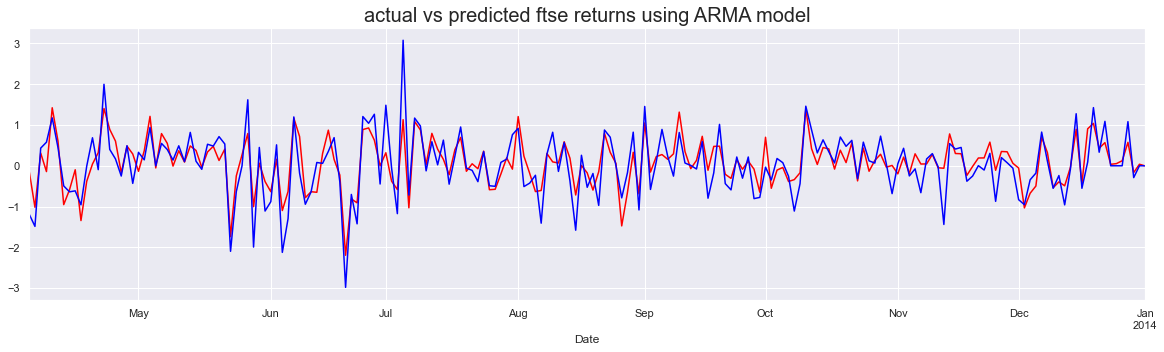

In [72]:
end_date= '2014-01-01'

model_ret_armax = ARIMA(df.ret_ftse[1:],exog=df[['ret_spx','ret_dax','ret_nikkei']][1:],order=(1,0,1))
result_ret_armax = model_ret_armax.fit()
df_pred_armax = result_ret_armax.predict(start_date,end_date,
                                         exog=df_test[['ret_spx','ret_dax','ret_nikkei']])
## the forcsting exog variable shoulf come from the testing set this is beacause the entire prediction interval
## falls outside the trainig set df
## no need to skip the first period,, as we have value there

df_pred_armax[start_date:end_date].plot(figsize=(20,5),color='red')
df_test.ret_ftse[start_date:end_date].plot(color='blue')
plt.title('actual vs predicted ftse returns using ARMA model',size=20)
plt.show()

In [73]:
## prediction has matched the true vlaue better than ever befre ,, in come instances the model overshoots the prediction
## while undershoots sometimes 
## but overall it follws the data very well 
# thus including outside factores like other market value indices improves the predictive power drastically 

## why??  because regualr ARMA model cannot incorporate outside real world effects 
## by including other market indices ,, we are allowing the model to take into account data from today as well as
## information from past periods
## this is extremely useful because it makes estimation a lot more precise 

In [74]:
## DOWNSIDE of maxmodel:: althought they can greaty improve the accuray of our prediction,, they can make forcasting
## impossible 

## predictions:  when we are using in-sample estimation
## forcast : out-of-sample estimation 

## if we have a tesing or validation set we can get the value we need for the exogenous variables so we make good predictions
## however we dont have them for periods in future so we could end up making poor forcast 

## here, we made fantastic prediction anout ftse_returns using snp, dax and nikkei_returns .. however we dont know
## what their value will be in the future so we cant make accurate forcast based on that 

In [ ]:
### Thus MAX model are useful when we are analyzing the data but poor when we are trying to forcast 

### ARIMA Model

In [ ]:
## prediciton will be intergated prices 
## have to create new series of integrated test prices 

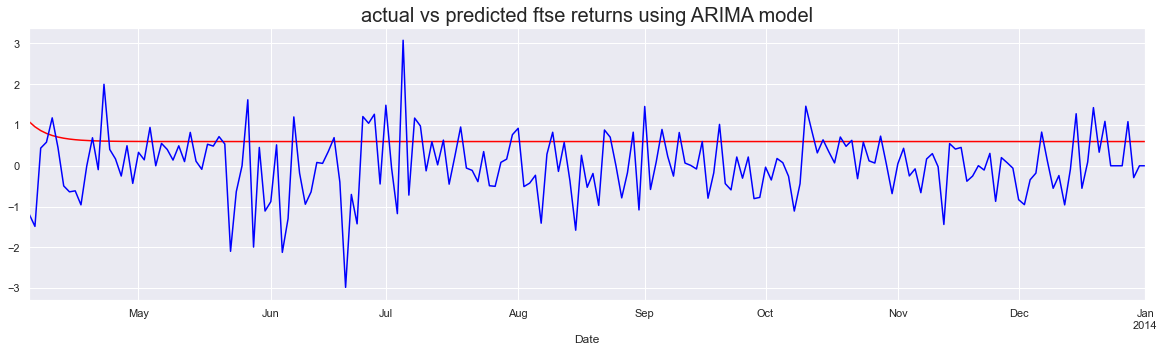

In [81]:
end_date= '2014-01-01'

model_arima = ARIMA(df.ftse,order=(1,1,1))
result_arima = model_arima.fit()
df_pred_arima = result_arima.predict(start_date,end_date)
## the forcsting exog variable shoulf come from the testing set this is beacause the entire prediction interval
## falls outside the trainig set df
## no need to skip the first period,, as we have value there

df_pred_arima[start_date:end_date].plot(figsize=(20,5),color='red')
df_test.ret_ftse[start_date:end_date].plot(color='blue')
plt.title('actual vs predicted ftse returns using ARIMA model',size=20)
plt.show()

### ARIMAX

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:796: SpecificationWarning: 
The number of observations in exog does not match the number of out-of-sample
observations.  This might indicate that exog is not correctly aligned. exog
should be aligned so that the exog[0] is used for the first out-of-sample
forecast, and exog[-1] is used for the last out-of-sample forecast.
exog is not used for in-sample observations which are the fitted values.

To silence this warning, ensure the number of observation in exog (1256)
matches the number of out-of-sample forecasts (195)'

  warnings.warn(msg, SpecificationWarning)


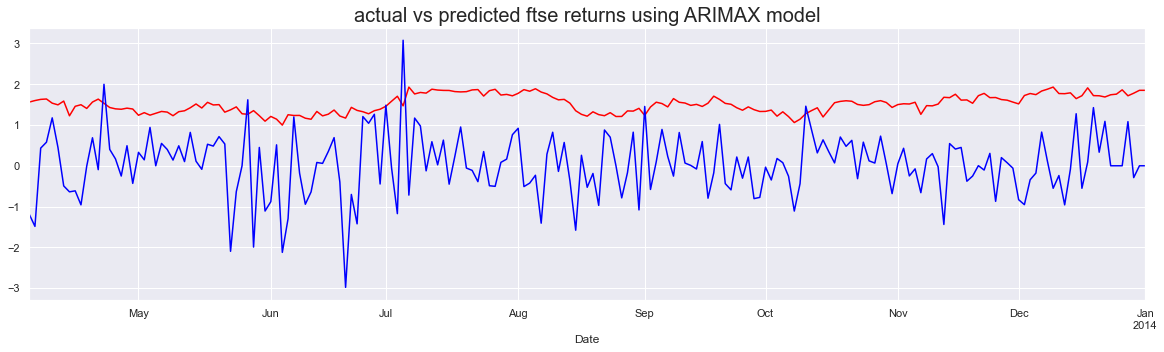

In [87]:
end_date= '2014-01-01'

model_arimax = ARIMA(df.ftse,order=(1,1,1),exog=df[['spx','dax','nikkei']])
result_arimax = model_arimax.fit()
df_pred_arimax = result_arimax.predict(start_date,end_date,
                                         exog=df_test[['spx','dax','nikkei']])
## the forcsting exog variable shoulf come from the testing set this is beacause the entire prediction interval
## falls outside the trainig set df
## no need to skip the first period,, as we have value there

df_pred_arimax[start_date:end_date].plot(figsize=(20,5),color='red')
df_test.ret_ftse[start_date:end_date].plot(color='blue')
plt.title('actual vs predicted ftse returns using ARIMAX model',size=20)
plt.show()

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:796: SpecificationWarning: 
The number of observations in exog does not match the number of out-of-sample
observations.  This might indicate that exog is not correctly aligned. exog
should be aligned so that the exog[0] is used for the first out-of-sample
forecast, and exog[-1] is used for the last out-of-sample forecast.
exog is not used for in-sample observations which are the fitted values.

To silence this warning, ensure the number of observation in exog (1256)
matches the number of out-of-sample forecasts (195)'

  warnings.warn(msg, SpecificationWarning)


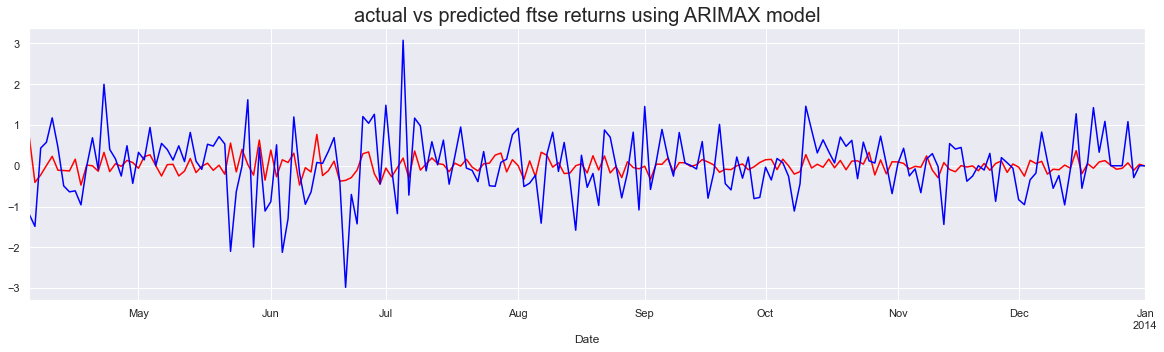

In [88]:
# using intergation order =2

end_date= '2014-01-01'

model_ret_arimax = ARIMA(df.ret_ftse[1:],exog=df[['ret_spx','ret_dax','ret_nikkei']][1:],order=(1,1,1))
result_ret_arimax = model_ret_arimax.fit()
df_pred_arimax = result_ret_arimax.predict(start_date,end_date,
                                         exog=df_test[['ret_spx','ret_dax','ret_nikkei']])
## the forcsting exog variable shoulf come from the testing set this is beacause the entire prediction interval
## falls outside the trainig set df
## no need to skip the first period,, as we have value there

df_pred_arimax[start_date:end_date].plot(figsize=(20,5),color='red')
df_test.ret_ftse[start_date:end_date].plot(color='blue')
plt.title('actual vs predicted ftse returns using ARIMAX model',size=20)
plt.show()

### SARMA

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


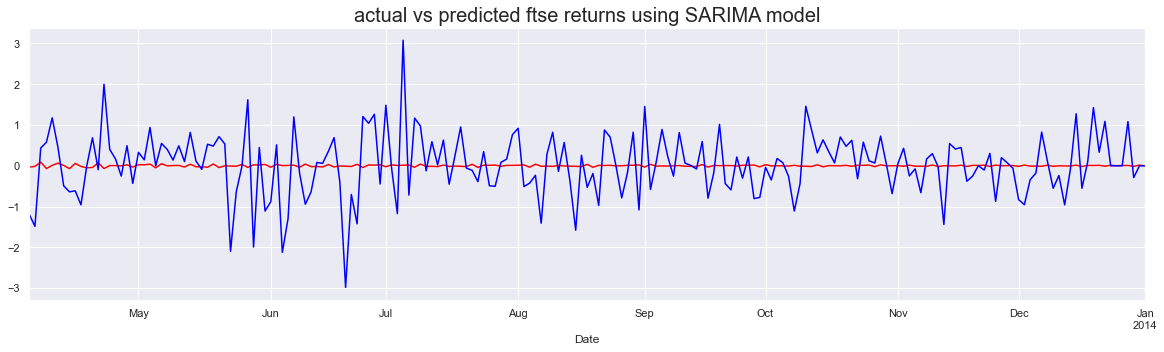

In [91]:
end_date= '2014-01-01'

model_sarma = SARIMAX(df.ret_ftse,order=(3,0,4), seasonal_order=(3,0,2,5))
## lenght of seasonal patterns : normal week consists of 5 business days
## the rest of the orders can vary as long as non-seasonal order are less than s=5
result_sarma = model_sarma.fit()
df_pred_sarma = result_sarma.predict(start_date,end_date)
## the forcsting exog variable shoulf come from the testing set this is beacause the entire prediction interval
## falls outside the trainig set df
## no need to skip the first period,, as we have value there

df_pred_sarma[start_date:end_date].plot(figsize=(20,5),color='red')
df_test.ret_ftse[start_date:end_date].plot(color='blue')
plt.title('actual vs predicted ftse returns using SARIMA model',size=20)
plt.show()

In [92]:
# most value close to zero as was the case aith ARMA model
# however the prediction curve is wiggly instead of being constanly decresig ,, the retuens are going up and down
## instead of behaving identical throughout the interval
## less spread than actual model,, SARMA model anticipates high stability than the MAX model we examined earlier 
## however their accuracy is lacking 

## if we zoom in ,,we can see our predictio hoing in opoostite directions 
## some point of matches, but we should not making our prediction solely based on these incidental matches 

### SARMAX

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


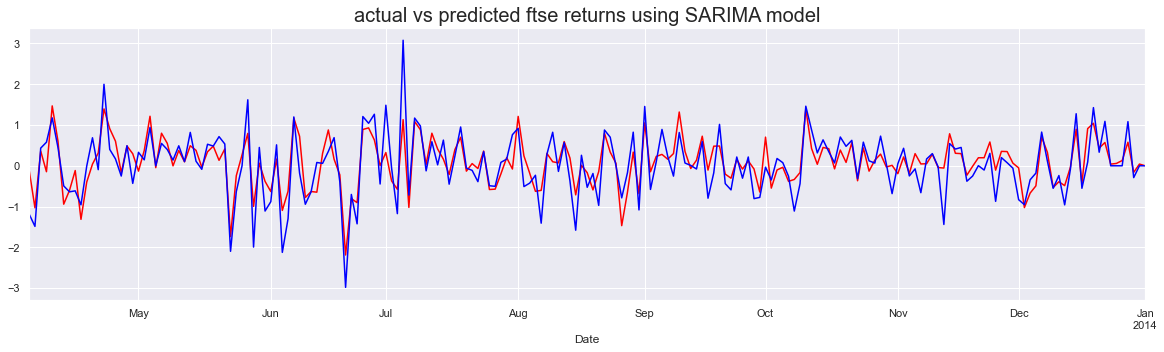

In [97]:
end_date= '2014-01-01'

model_sarmax = SARIMAX(df.ret_ftse[1:],order=(3,0,4), seasonal_order=(3,0,2,5), exog= df[['ret_spx','ret_dax','ret_nikkei']][1:])
## lenght of seasonal patterns : normal week consists of 5 business days
## the rest of the orders can vary as long as non-seasonal order are less than s=5
result_sarmax = model_sarmax.fit()
df_pred_sarmax = result_sarmax.predict(start_date,end_date, exog=df_test[['ret_spx','ret_dax','ret_nikkei']][start_date:end_date])
## the forcsting exog variable shoulf come from the testing set this is beacause the entire prediction interval
## falls outside the trainig set df
## no need to skip the first period,, as we have value there

df_pred_sarmax[start_date:end_date].plot(figsize=(20,5),color='red')
df_test.ret_ftse[start_date:end_date].plot(color='blue')
plt.title('actual vs predicted ftse returns using SARIMA model',size=20)
plt.show()

In [98]:
# here we are combining the peculiarity of max models and seasonal models
## we can see the curve that follows the data very closly 
## similar improvment occured when we went from ARMA to ARMAX,, so adding exog variable drastically changes our predictions
## ehnce the best estimates seems to be one where we are adding exog variabels 

### Auto ARIMA 

In [101]:
model_auto = auto_arima(df.ret_ftse[1:]) ## returns the fitted model 



In [100]:
## returns an np-array instead of df 

In [102]:
df_auto_pred = pd.DataFrame(model_auto.predict(n_periods=len(df_test[start_date:end_date])),
                            index=df_test[start_date:end_date].index)

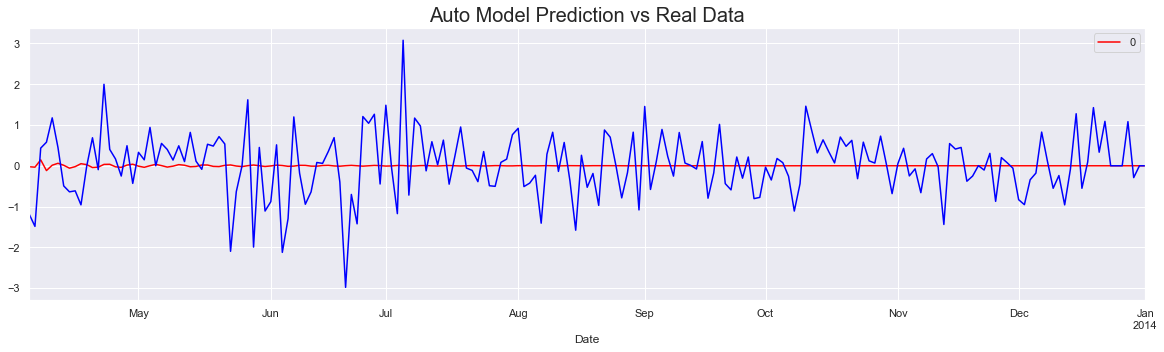

In [103]:
df_auto_pred.plot(figsize=(20,5),color='red')
df_test.ret_ftse[start_date:end_date].plot(color='blue')
plt.title('Auto Model Prediction vs Real Data',size=20)
plt.show()

In [104]:
## this predicted model does not predict the graph as well as SARMAX model did 
## this is only the default best model so we should not be too bothered about its accuracy 
## to make the prediction better : pass the exogenous argument 
## since we expect cyclical trends in the model, we can set the lenght of each season m variabel 
## we can loosen the restriction by increasing the maximum allowed value of the seasonal and non-seasonal order 
## this allows auto_arima to explore even SARIMAX models rather than just be confined to ARIMA 

In [105]:
## AUTO ARIMA WITH LESS RESTRICTIONS



In [106]:
model_auto = auto_arima(df.ret_ftse[1:], exogenous=df[['ret_spx','ret_dax','ret_nikkei']][1:], m=5, max_p=5,
                       max_q=5, max_P=5, max_Q=5)

In [110]:
df_auto_pred_2 = pd.DataFrame(model_auto.predict(n_periods=len(df_test[start_date:end_date]),
                              exogenous = df_test[['ret_spx','ret_dax','ret_nikkei']][start_date:end_date]),
                            index=df_test[start_date:end_date].index)

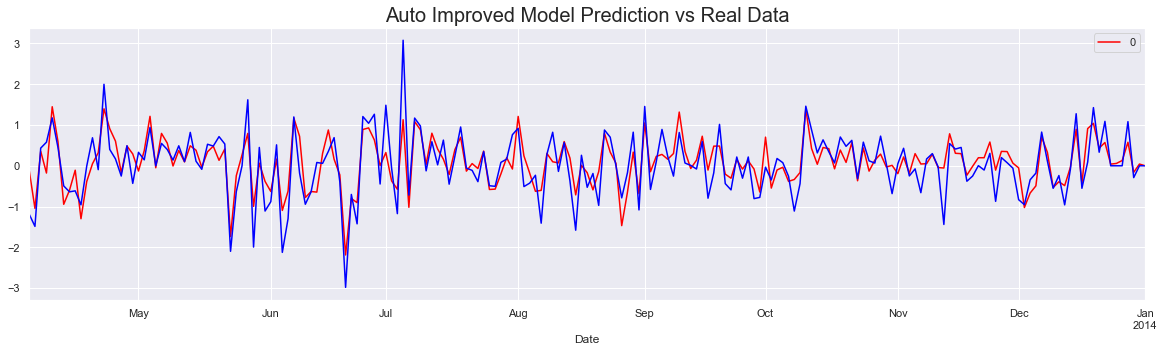

In [111]:
df_auto_pred_2.plot(figsize=(20,5),color='red')
df_test.ret_ftse[start_date:end_date].plot(color='blue')
plt.title('Auto Improved Model Prediction vs Real Data',size=20)
plt.show()

In [ ]:
## AS LONG as we provide the auto_arima method with enough information ,, it's bound to give us the reasonable
## solution 
## all the model that performed well relied on exogenous variable 

## but exogeneous variable are hardly ever available in the long run 
## out MAX model rely on outside data much more than they do on past_values(AR) or past errors (MA)

### Comparing all the model Returns

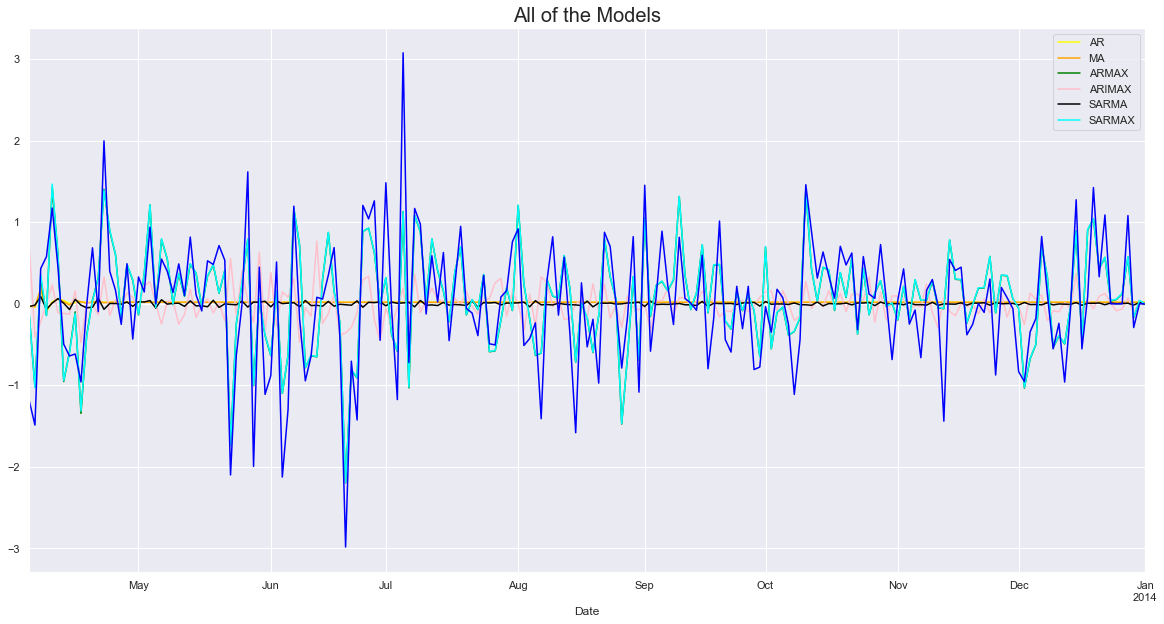

In [127]:
end_date = '2014-01-01'
df_predict_ret_ar[start_date:end_date].plot(figsize=(20,10),color='yellow')
df_pred_ar_4_ma_4[start_date:end_date].plot(color='orange')
df_pred_armax[start_date:end_date].plot(color='green')
# df_pred_arima[start_date:end_date].plot(color='red')
df_pred_arimax[start_date:end_date].plot(color='pink')
df_pred_sarma[start_date:end_date].plot(color='black')
df_pred_sarmax[start_date:end_date].plot(color='cyan')
df_test.ret_ftse[start_date:end_date].plot(color='blue')
plt.legend(['AR','MA','ARMAX','ARIMAX','SARMA','SARMAX'])
plt.title('All of the Models',size=20)
plt.show()

In [ ]:
## blue curve is the actual data 
## we dont see curve for AR and MA models,, since python layes the value on top of one another 

In [ ]:
## AR model only depends on past values and constant coefficients ,, thus we are getting curve of constantly decresing value
## the more past lags we include the more time it takes to flatten out -- the monotonous nature of prediction makes
## it unreasonable since we dont expect prices and return to constanly be going down 

In [128]:
## MA models,, we can't make long run predictions if we are relying on error terms -- it is because we cannot
## autogenerate future residuals since we dont have actual values anymore

## thus any model that relies on error term is not suitable for forcasting many periods ahead 

## one way to resolve this issue is manually create a whitenoise residual values for the entire time period we are 
## forcasting -- then we can recursively create a time series of predictions based on the regression coefficient
## and the last few known residuals 

In [129]:
## ARMA is combintation of AR and MA models,, thus prone to experiencing both types of errors (for both MA and AR)
## by creating the artificaial (ma) residuals ,, we get rid of MA issues  and since we are not only dependent on AR
## components anymore WE ALSO get rid of AR issues 

In [130]:
## if the exogenous variable are other time series as well ,, we will run into some trouble 
## not knowing how the exogenous variabel shifts make it impossible to predict how the endogenous would do that either

In [131]:
## making accurate prediction with ARMA familyof models is not that easy
## what if we don't forcast the values themselves?  instead we can focus on their volatility to determine the stabilty
## of some markets


### Forecasting Volatility

In [133]:
## need to pass entire data as the endogeneous variable rather than the training set alone

In [134]:
model_garch = arch_model(df_comp.ret_ftse[1:],vol='GARCH',mean='constant', p=1,q=1, dist='Normal')
res_garch = model_garch.fit(last_obs=start_date, update_freq=10) # last observation= start of prediction ensure we are fitting only the trainig set into the model

Iteration:     10,   Func. Count:     73,   Neg. LLF: 6965.8227588267855
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6965.783615832825
            Iterations: 13
            Function evaluations: 91
            Gradient evaluations: 13


In [135]:
pred_grach = res_garch.forecast(horizon=1, align='target')

In [ ]:
## horizon = how many observation we want our model to predict for each date 
## 1 means for each date we will get the predicted vlaue for the next date 
## align - determines whether we match the value with the date the prediciton is made on , or the one it;s supposed to
# represent  

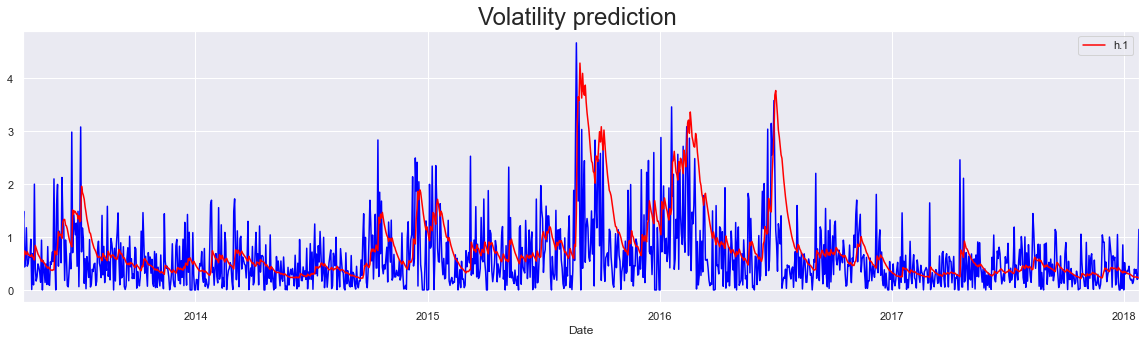

In [138]:
pred_grach.residual_variance[start_date:].plot(figsize=(20,5),color='red',zorder=2)
df_test.ret_ftse.abs().plot(color='blue',zorder=1) # since volatility is always postitve thus we opt for abs value
plt.title('Volatility prediction ',size=24)
plt.show()

In [ ]:
## our model does a decent job precting when shocks will happen  and does very well at deteriming periods 
## of consecutive high and low volatility 

In [ ]:
# we see a curve that fluctuates up and down and shows no obvious pattern -- our volaity prediction are not liniear like
## the ARMA model
## but fluctuates based on past conditional variance 

In [140]:
## we are only testing the model on the test set rather than forecasting the future but we can do so using the 
## horizon argument
## we use many step ahead prediction for singlw day 
## and set the last date of our dataset to start predicting

In [141]:
pred_grach = res_garch.forecast(horizon=100, align='target')
pred_grach.residual_variance[-1:]


,h.001,h.002,h.003,h.004,h.005,h.006,h.007,h.008,h.009,h.010,...,h.091,h.092,h.093,h.094,h.095,h.096,h.097,h.098,h.099,h.100
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-24,0.228437,0.245741,0.260707,0.271255,0.280474,0.284246,0.300304,0.31852,0.337886,0.35853,...,0.939559,0.958068,0.970377,0.934355,0.890057,0.900268,0.913663,0.921389,0.933742,0.938429


In [142]:
## number after h shows the which day of the prediction we are on 

In [143]:
## we are predicting volatility rather than returns and we cant tranform those to get some price estimates 

In [144]:
## This is one of the ways we can go around this issue of missing exogeneous variable ...
## or we can forecast the value of each of those exogeneous variale as well

### Multivariate Forecasting